In [1]:
from transformers import GPTNeoForCausalLM, GPT2Tokenizer
import torch
import torch.nn as nn
from collections import OrderedDict
import numpy as np 
from transformers import AutoTokenizer, AutoModelForCausalLM

class NewModel(nn.Module):
    def __init__(self, *args):
        super().__init__(*args)
        self.pretrained = GPTNeoForCausalLM.from_pretrained("EleutherAI/gpt-neo-2.7B")
        self.tokenizer = GPT2Tokenizer.from_pretrained("EleutherAI/gpt-neo-2.7B")
        # self.pretrained = AutoModelForCausalLM.from_pretrained("unsloth/phi-4")  # Use the Phi-4 model
        # self.tokenizer = AutoTokenizer.from_pretrained("unsloth/phi-4")
        self.output_layers = [1]
        self.selected_out = OrderedDict()
        self.fhooks = []

        for i,l in enumerate(list(self.pretrained._modules.keys())):
            if i in self.output_layers:
                self.fhooks.append(getattr(self.pretrained,l).register_forward_hook(self.forward_hook(l)))

    def forward_hook(self,layer_name):
        def hook(module, input, output):
            self.selected_out[layer_name] = output
        return hook

    def forward(self, x):
        out = self.pretrained(x)
        return out, self.selected_out

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Now, move the model to the appropriate device
model = NewModel().to(device)

prompt = (
    "Where is the best place to go for a vacation in the summer?"
)

input_ids = model.tokenizer(prompt, return_tensors="pt").input_ids.to(device)

gen_tokens = model.pretrained.generate(
    input_ids,
    do_sample=True,
    temperature=0.9,
    max_length=100,
)
gen_text = model.tokenizer.batch_decode(gen_tokens)[0]

print(gen_text)
# Print the raw tensor output (before flattening)
print([value for value in model.selected_out.values()])

# Extract the tensor from the selected output layers (assuming it's the first item)
tensor = list(model.selected_out.values())[0]

# Move the tensor to CPU (if it's on GPU)
tensor_cpu = tensor.cpu()

# Convert the tensor to a NumPy array
numpy_array = tensor_cpu.detach().numpy()  # Detach from computation graph

# Flatten the numpy array and save it to a text file
np.savetxt('tensor_output.txt', numpy_array.flatten())  # Flatten to store as a single line of numbers

config.json:   0%|          | 0.00/1.46k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/10.7G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/200 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/90.0 [00:00<?, ?B/s]

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


Where is the best place to go for a vacation in the summer? With beaches in Maine and the Adirondacks, summertime in New York, Vermont and Maine, or summer in Maine, Vermont, New Hampshire, and Canada there are so many great places for a visit. And if you just want to take it easy, then Vermont, or Maine, or even Canada is the way to go. However, summer is a hard time to go back to school. In fact, many kids
[tensor([[[-12.4587, -12.6178, -17.0289,  ..., -14.6456, -19.0371, -12.7493]]],
       device='cuda:0')]


In [2]:
import torch
from transformers import GPT2LMHeadModel, GPT2Tokenizer,GPTNeoForCausalLM
import json
import numpy as np

class ActivationDatasetGenerator:
    def __init__(self, model_name="EleutherAI/gpt-neo-2.7B", device="cuda" if torch.cuda.is_available() else "cpu"):
        self.device = device
        self.tokenizer = GPT2Tokenizer.from_pretrained(model_name)
        self.model = GPTNeoForCausalLM.from_pretrained(model_name).to(self.device)
        self.model.eval()
        self.tokenizer.pad_token = self.tokenizer.eos_token
        self.activations = []

        def hook_fn(module, input, output):
            self.activations = output[0].detach().cpu().numpy()  # Overwrite, not append

        self.hook_layer = self.model.transformer.h[16]  # Middle layer (32 layers total)
        self.hook_handle = self.hook_layer.register_forward_hook(hook_fn)

    def generate_text_and_activations(self, prompt, max_length=50):
        self.activations = []
        inputs = self.tokenizer(prompt, return_tensors="pt", padding=True, truncation=True).to(self.device)
        with torch.no_grad():
            output = self.model.generate(
                inputs["input_ids"],
                attention_mask=inputs["attention_mask"],
                max_length=max_length,
                pad_token_id=self.tokenizer.eos_token_id
            )
        text = self.tokenizer.decode(output[0], skip_special_tokens=True)
        return text, self.activations if self.activations.size else None

    def process_dataset(self, prompts, save_path="activations_data.json"):
        dataset = []
        for idx, prompt in enumerate(prompts):
            print(f"Processing {idx+1}/{len(prompts)}: {prompt[:50]}...")
            text, activation = self.generate_text_and_activations(prompt)
            if activation is not None:
                dataset.append({
                    "prompt": prompt,
                    "generated_text": text,
                    "activations": activation.tolist()
                })
        with open(save_path, "w") as f:
            json.dump(dataset, f, indent=4)
        print(f"Dataset saved to {save_path}")

# Example usage
if __name__ == "__main__":
    prompts = [
        "What is the best way to learn machine learning?",
        "Explain quantum computing in simple terms.",
        "Tell me a joke about programming.",
        "What happens if you fall into a black hole?",
        "Describe the future of artificial intelligence.",
        "Write a Python function to reverse a linked list.",
        "Explain why recursion is useful in programming.",
        "What is the role of a CPU in modern computing?",
        "Explain how virtual memory works in an operating system.",
        "What are the ethical challenges of artificial intelligence?",
        "How does a neural network learn from data?",
        "How does gradient descent optimize a machine learning model?",
        "Explain the difference between supervised and unsupervised learning.",
        "write python function to generate random numbers",
        "What happens when you type a URL into a browser?"
        "Explain the concept of cloud computing in simple terms."
        
    ]

    generator = ActivationDatasetGenerator()
    generator.process_dataset(prompts)


Processing 1/15: What is the best way to learn machine learning?...
Processing 2/15: Explain quantum computing in simple terms....
Processing 3/15: Tell me a joke about programming....
Processing 4/15: What happens if you fall into a black hole?...
Processing 5/15: Describe the future of artificial intelligence....
Processing 6/15: Write a Python function to reverse a linked list....
Processing 7/15: Explain why recursion is useful in programming....
Processing 8/15: What is the role of a CPU in modern computing?...
Processing 9/15: Explain how virtual memory works in an operating s...
Processing 10/15: What are the ethical challenges of artificial inte...
Processing 11/15: How does a neural network learn from data?...
Processing 12/15: How does gradient descent optimize a machine learn...
Processing 13/15: Explain the difference between supervised and unsu...
Processing 14/15: write python function to generate random numbers...
Processing 15/15: What happens when you type a URL into a

In [3]:
with open("activations_data.json", "r") as f:
    data = json.load(f)
for i, item in enumerate(data):
    print(f"Prompt {i+1} activation shape: {np.array(item['activations']).shape}")

Prompt 1 activation shape: (1, 1, 2560)
Prompt 2 activation shape: (1, 1, 2560)
Prompt 3 activation shape: (1, 1, 2560)
Prompt 4 activation shape: (1, 1, 2560)
Prompt 5 activation shape: (1, 1, 2560)
Prompt 6 activation shape: (1, 1, 2560)
Prompt 7 activation shape: (1, 1, 2560)
Prompt 8 activation shape: (1, 1, 2560)
Prompt 9 activation shape: (1, 1, 2560)
Prompt 10 activation shape: (1, 1, 2560)
Prompt 11 activation shape: (1, 1, 2560)
Prompt 12 activation shape: (1, 1, 2560)
Prompt 13 activation shape: (1, 1, 2560)
Prompt 14 activation shape: (1, 1, 2560)
Prompt 15 activation shape: (1, 1, 2560)


In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import json
import numpy as np

# Function to pad activations
def pad_activations(activations_batch):
    max_len = max([a.size(1) for a in activations_batch])
    padded_activations = [F.pad(a.squeeze(0), (0, 0, 0, max_len - a.size(1))) for a in activations_batch]
    return torch.stack(padded_activations)

# Sparse Autoencoder class
class SparseAutoencoder(nn.Module):
    def __init__(self, input_dim=2560, encoder_dim=5120, sparsity_penalty=0.001):
        super().__init__()
        self.encoder = nn.Sequential(nn.Linear(input_dim, encoder_dim), nn.ReLU(True))
        self.decoder = nn.Sequential(nn.Linear(encoder_dim, input_dim), nn.ReLU(True))
        self.sparsity_penalty = sparsity_penalty

    def forward(self, x):
        z = self.encoder(x)
        reconstructed = self.decoder(z)
        return reconstructed, z

    def l1_regularization(self, z):
        return torch.sum(torch.abs(z))

# Load activations from Task 2
with open("activations_data.json", "r") as f:
    data = json.load(f)
activations_batch = [torch.tensor(item["activations"], dtype=torch.float32) for item in data]
padded_activations = pad_activations(activations_batch)

# Split into train and validation (80-20 split)
train_size = int(0.8 * len(padded_activations))
train_data = padded_activations[:train_size]
val_data = padded_activations[train_size:]

# Hyperparameters
input_dim = 2560  # GPT-Neo-2.7B hidden size
encoder_dim = 5120  # 2x input_dim
sparsity_penalty = 0.001

# Instantiate model and optimizer
autoencoder = SparseAutoencoder(input_dim, encoder_dim, sparsity_penalty)
optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)

# Training loop with early stopping
num_epochs = 50
patience = 5
best_val_loss = float("inf")
patience_counter = 0

for epoch in range(num_epochs):
    autoencoder.train()
    optimizer.zero_grad()

    # Forward pass (training)
    train_input = train_data.view(-1, input_dim)  # [batch_size * seq_len, hidden_dim]
    reconstructed, encoded = autoencoder(train_input)
    recon_loss = F.mse_loss(reconstructed, train_input)
    l1_loss = autoencoder.l1_regularization(encoded)
    total_loss = recon_loss + sparsity_penalty * l1_loss

    # Backpropagation
    total_loss.backward()
    optimizer.step()

    # Validation
    autoencoder.eval()
    with torch.no_grad():
        val_input = val_data.view(-1, input_dim)
        val_reconstructed, val_encoded = autoencoder(val_input)
        val_loss = F.mse_loss(val_reconstructed, val_input)

    # Sparsity metric
    sparsity = (encoded.abs() < 0.01).float().mean().item()  # Fraction of near-zero values

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {total_loss.item():.4f}, Val Loss: {val_loss.item():.4f}, Sparsity: {sparsity:.4f}")

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(autoencoder.state_dict(), "best_sparse_autoencoder.pth")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered")
            break

# Load best model
autoencoder.load_state_dict(torch.load("best_sparse_autoencoder.pth"))
print("Training complete. Best model saved.")

Epoch 1/50, Train Loss: 604.1283, Val Loss: 334.6634, Sparsity: 0.4993
Epoch 2/50, Train Loss: 464.5082, Val Loss: 329.0937, Sparsity: 0.6416
Epoch 3/50, Train Loss: 379.7078, Val Loss: 332.2801, Sparsity: 0.7851
Epoch 4/50, Train Loss: 340.5775, Val Loss: 335.5902, Sparsity: 0.9040
Epoch 5/50, Train Loss: 327.6548, Val Loss: 337.6063, Sparsity: 0.9757
Epoch 6/50, Train Loss: 325.6721, Val Loss: 338.4254, Sparsity: 0.9981
Epoch 7/50, Train Loss: 325.6062, Val Loss: 338.6352, Sparsity: 0.9999
Early stopping triggered
Training complete. Best model saved.


/tmp/ipykernel_171791/2183414401.py:95: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  autoencoder.load_state_dict(torch.load("best_sparse_autoencoder.pth"))


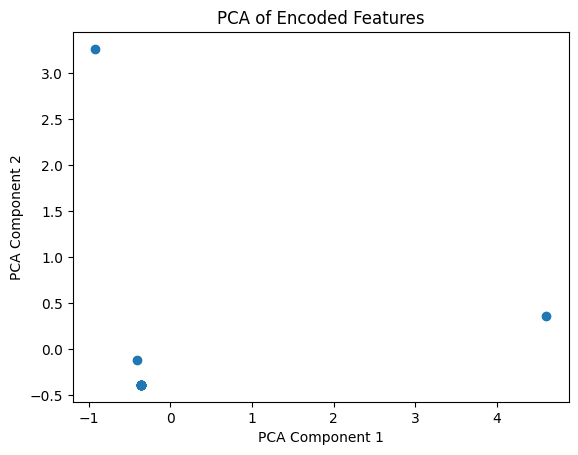

In [5]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Assuming 'encoded' contains the compressed activations after training
encoded_data = encoded.detach().cpu().numpy()  # Moving to CPU if using GPU

# Apply PCA or t-SNE to reduce dimensionality for visualization
pca = PCA(n_components=2)
pca_result = pca.fit_transform(encoded_data)

# Plot the 2D projection of the encoded features
plt.scatter(pca_result[:, 0], pca_result[:, 1])
plt.title('PCA of Encoded Features')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()


In [6]:
import torch
import json
import numpy as np

# Load trained autoencoder
autoencoder.eval()

# Load activation data
with open("activations_data.json", "r") as f:
    data = json.load(f)

# Store encoded representations and their prompts
encoded_outputs = []
text_snippets = []

with torch.no_grad():
    for item in data:
        text = item["prompt"]  # Extract the original prompt
        act_tensor = torch.tensor(item["activations"], dtype=torch.float32)  # Convert to tensor

        # Reshape to match expected input shape
        act_tensor = act_tensor.view(1, -1)  # Shape: [1, 2560]

        # Pass through encoder
        z = autoencoder.encoder(act_tensor)  # Shape: [1, encoder_dim]

        # Convert to numpy for analysis
        encoded_outputs.append(z.squeeze(0).cpu().numpy())  # Shape: [encoder_dim]
        text_snippets.append(text)

# Convert to numpy array
encoded_outputs = np.stack(encoded_outputs)  # Shape: [num_samples, encoder_dim]

print("Encoded features extracted successfully!")


Encoded features extracted successfully!


In [7]:
def get_top_activating_texts(encoded_outputs, text_snippets, top_k=5):
    num_features = encoded_outputs.shape[1]  # Number of encoded dimensions
    features = []

    for dim in range(num_features):
        dim_activations = encoded_outputs[:, dim]  # Get activations for this feature
        top_indices = np.argsort(dim_activations)[-top_k:]  # Indices of top activations
        top_texts = [text_snippets[i] for i in reversed(top_indices)]  # Highest first

        features.append({
            "dimension": dim,
            "top_texts": top_texts,
            "activations": [dim_activations[i] for i in reversed(top_indices)]
        })

    return features

# Get top 5 text prompts per feature dimension
interpretable_features = get_top_activating_texts(encoded_outputs, text_snippets, top_k=5)

# Print results for inspection
for feat in interpretable_features[:10]:  # Check first 10 dimensions
    print(f"--- Dimension {feat['dimension']} ---")
    for i, (text, score) in enumerate(zip(feat["top_texts"], feat["activations"])):
        print(f"{i+1}. ({score:.4f}) {text}")
    print("\n")


--- Dimension 0 ---
1. (1.5881) Explain the difference between supervised and unsupervised learning.
2. (0.3513) How does a neural network learn from data?
3. (0.0000) What happens when you type a URL into a browser?Explain the concept of cloud computing in simple terms.
4. (0.0000) write python function to generate random numbers
5. (0.0000) How does gradient descent optimize a machine learning model?


--- Dimension 1 ---
1. (0.0000) What happens when you type a URL into a browser?Explain the concept of cloud computing in simple terms.
2. (0.0000) write python function to generate random numbers
3. (0.0000) Explain the difference between supervised and unsupervised learning.
4. (0.0000) How does gradient descent optimize a machine learning model?
5. (0.0000) How does a neural network learn from data?


--- Dimension 2 ---
1. (0.0000) What happens when you type a URL into a browser?Explain the concept of cloud computing in simple terms.
2. (0.0000) write python function to generate ra

In [8]:
# Print results for inspection
for feat in interpretable_features[:50]:  # Check first 10 dimensions
    print(f"--- Dimension {feat['dimension']} ---")
    for i, (text, score) in enumerate(zip(feat["top_texts"], feat["activations"])):
        print(f"{i+1}. ({score:.4f}) {text}")
    print("\n")

--- Dimension 0 ---
1. (1.5881) Explain the difference between supervised and unsupervised learning.
2. (0.3513) How does a neural network learn from data?
3. (0.0000) What happens when you type a URL into a browser?Explain the concept of cloud computing in simple terms.
4. (0.0000) write python function to generate random numbers
5. (0.0000) How does gradient descent optimize a machine learning model?


--- Dimension 1 ---
1. (0.0000) What happens when you type a URL into a browser?Explain the concept of cloud computing in simple terms.
2. (0.0000) write python function to generate random numbers
3. (0.0000) Explain the difference between supervised and unsupervised learning.
4. (0.0000) How does gradient descent optimize a machine learning model?
5. (0.0000) How does a neural network learn from data?


--- Dimension 2 ---
1. (0.0000) What happens when you type a URL into a browser?Explain the concept of cloud computing in simple terms.
2. (0.0000) write python function to generate ra